# MNIST with SciKit-Learn and skorch

This notebooks shows how to define and train a simple Neural-Network with PyTorch and use it via skorch with SciKit-Learn.

<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href="https://github.com/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

**Note**: If you are running this in [a colab notebook](https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb), we recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

If you are running in colab, you should install the dependencies and download the dataset by running the following cell:

In [1]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch'])
except ImportError:
    pass

In [2]:
import torch
import skorch
print("torch:", torch.__version__)
print("skorch:", skorch.__version__)
print("CUDA available:", torch.cuda.is_available())


torch: 2.9.0+cpu
skorch: 1.3.1
CUDA available: False


In [38]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

SEED = 42
torch.manual_seed(SEED)


In [39]:
ROOT = "./data"

to_tensor_only = transforms.ToTensor()

mnist_train_raw = datasets.MNIST(
    root=ROOT,
    train=True,
    download=True,
    transform=to_tensor_only
)

mnist_test_raw = datasets.MNIST(
    root=ROOT,
    train=False,
    download=True,
    transform=to_tensor_only
)

print(len(mnist_train_raw), len(mnist_test_raw))


100%|██████████| 9.91M/9.91M [00:00<00:00, 55.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 2.05MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.47MB/s]

60000 10000


In [40]:
pixels = mnist_train_raw.data.float() / 255.0  # (60000, 28, 28) en float [0,1]
mean = pixels.mean().item()
std  = pixels.std().item()

print("mean =", mean)
print("std  =", std)


mean = 0.13066047430038452
std  = 0.30810782313346863


In [41]:
final_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,)),
    transforms.Lambda(lambda x: torch.flatten(x))  # 1x28x28 -> 784
])



In [42]:
mnist_train = datasets.MNIST(root=ROOT, train=True,  download=True, transform=final_transform)
mnist_test  = datasets.MNIST(root=ROOT, train=False, download=True, transform=final_transform)


In [43]:
train_size = 54000
val_size   = 6000

generator = torch.Generator().manual_seed(SEED)
train_ds, val_ds = random_split(mnist_train, [train_size, val_size], generator=generator)

print(len(train_ds), len(val_ds), len(mnist_test))


54000 6000 10000


In [44]:
BATCH_SIZE = 128

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=False)


In [45]:
X, y = next(iter(train_loader))
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X min/max:", X.min().item(), X.max().item())
print("Labels example:", y[:10].tolist())


X shape: torch.Size([128, 784])
y shape: torch.Size([128])
X min/max: -0.42407387495040894 2.8215432167053223
Labels example: [2, 0, 9, 9, 1, 8, 3, 6, 9, 1]


In [46]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=(256, 128), output_size=10, dropout=0.2):
        super().__init__()

        layers = []
        prev = input_size

        for h in hidden_sizes:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            if dropout and dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev = h

        layers.append(nn.Linear(prev, output_size))  # output = logits (pas de softmax ici)

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

model = MLP(hidden_sizes=(256, 128), dropout=0.2)
print(model)


MLP(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [47]:
X, y = next(iter(train_loader))  # vient du point 3
out = model(X)

print("Input shape:", X.shape)    # attendu: [batch_size, 784]
print("Output shape:", out.shape) # attendu: [batch_size, 10]


Input shape: torch.Size([128, 784])
Output shape: torch.Size([128, 10])


In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print("Using device:", device)


Using device: cpu


In [49]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 5


In [50]:
def accuracy_from_logits(logits, y_true):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == y_true).sum().item()
    return correct

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for X, y in loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        batch_size = y.size(0)
        total_loss += loss.item() * batch_size
        total_correct += accuracy_from_logits(logits, y)
        total_samples += batch_size

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    return avg_loss, avg_acc

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for X, y in loader:
        X, y = X.to(device), y.to(device)

        logits = model(X)
        loss = criterion(logits, y)

        batch_size = y.size(0)
        total_loss += loss.item() * batch_size
        total_correct += accuracy_from_logits(logits, y)
        total_samples += batch_size

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    return avg_loss, avg_acc


In [51]:
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(
        f"Epoch {epoch:02d}/{EPOCHS} | "
        f"Train: loss={train_loss:.4f}, acc={train_acc:.4f} | "
        f"Val: loss={val_loss:.4f}, acc={val_acc:.4f}"
    )


Epoch 01/5 | Train: loss=0.3298, acc=0.8994 | Val: loss=0.1511, acc=0.9527
Epoch 02/5 | Train: loss=0.1405, acc=0.9572 | Val: loss=0.1115, acc=0.9657
Epoch 03/5 | Train: loss=0.1083, acc=0.9671 | Val: loss=0.0980, acc=0.9708
Epoch 04/5 | Train: loss=0.0863, acc=0.9724 | Val: loss=0.0935, acc=0.9723
Epoch 05/5 | Train: loss=0.0728, acc=0.9774 | Val: loss=0.0804, acc=0.9765


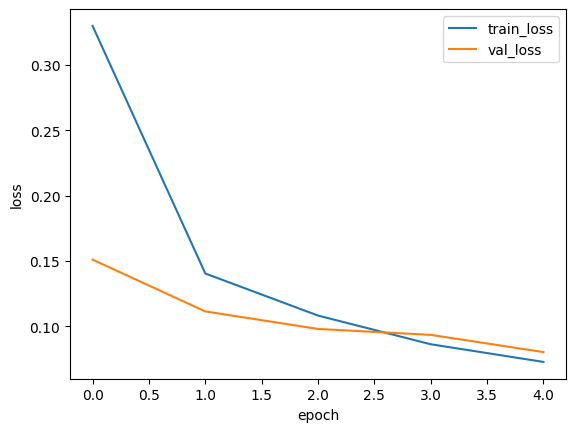

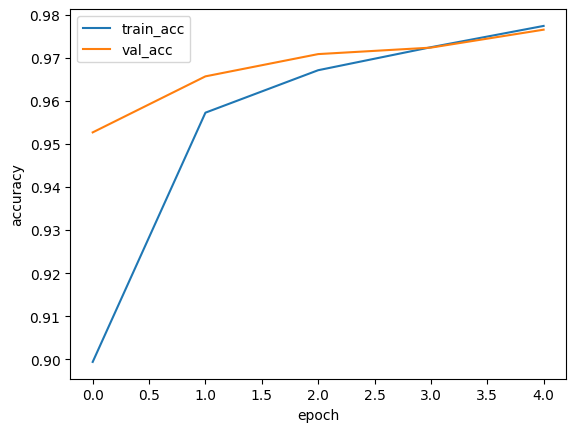

In [52]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [53]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"TEST: loss={test_loss:.4f}, acc={test_acc:.4f}")


TEST: loss=0.0800, acc=0.9752


In [54]:
import torch
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        logits = model(X)
        preds = torch.argmax(logits, dim=1).cpu()

        y_pred.append(preds)
        y_true.append(y)

y_true = torch.cat(y_true).numpy()
y_pred = torch.cat(y_pred).numpy()

cm = confusion_matrix(y_true, y_pred, labels=list(range(10)))
print(cm)


[[ 969    0    0    1    1    0    2    2    3    2]
 [   0 1127    4    0    0    0    0    1    3    0]
 [   1    2  981   10    6    0    0   19   13    0]
 [   0    0    1  994    0    2    0    6    3    4]
 [   1    0    5    0  964    0    2    2    0    8]
 [   2    0    0   19    3  854    5    1    4    4]
 [   4    3    0    1    9    5  932    0    4    0]
 [   0    4    4    1    2    0    0 1009    1    7]
 [   5    0    1    7    4    2    2    5  944    4]
 [   1    3    0    6   12    1    1    4    3  978]]


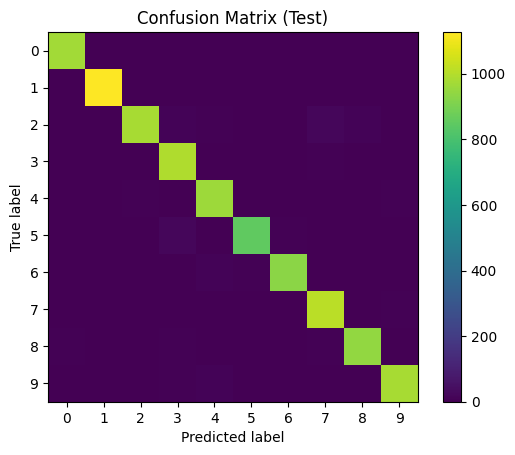

In [55]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.colorbar()
plt.show()


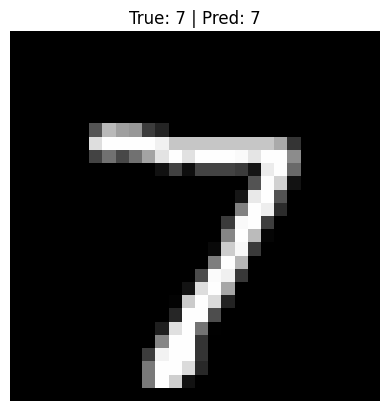

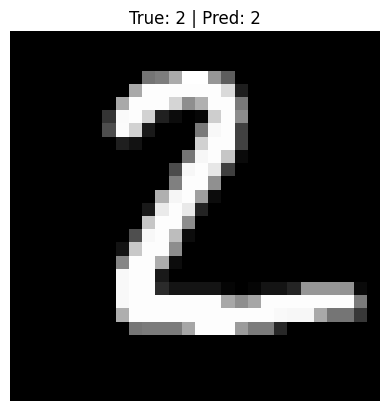

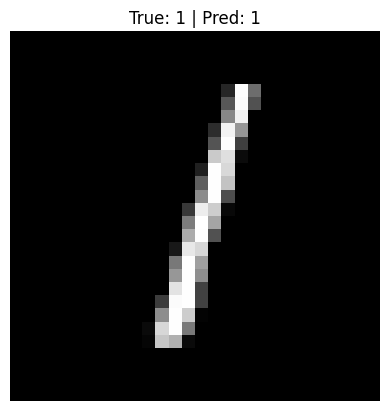

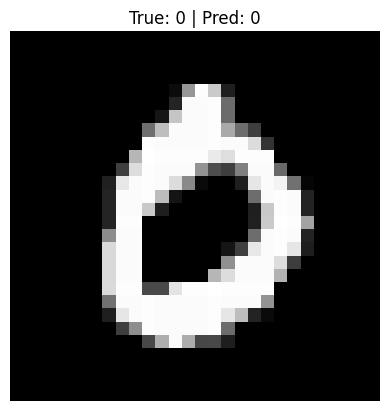

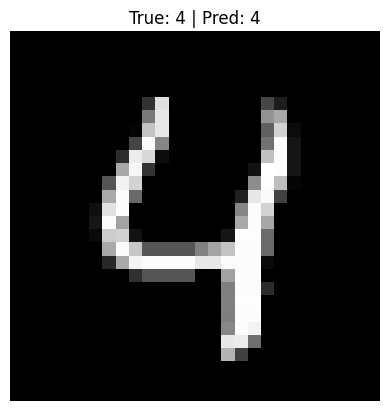

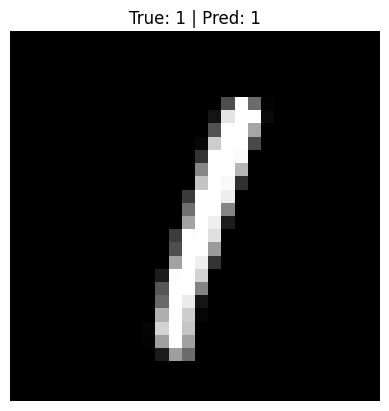

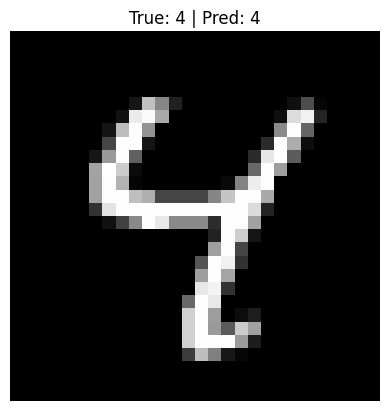

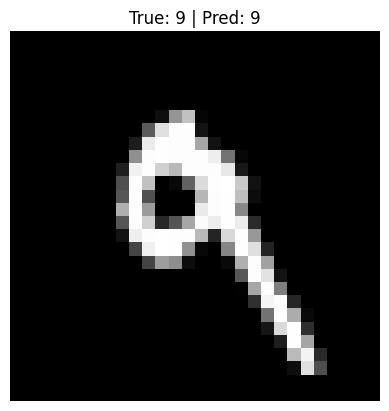

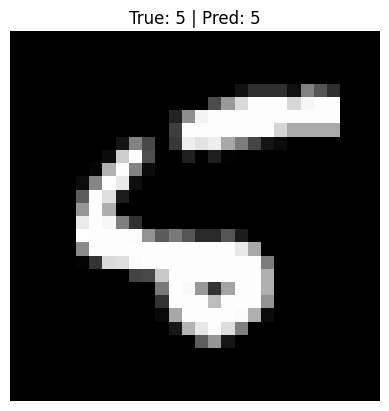

In [56]:
import matplotlib.pyplot as plt
import torch

X, y = next(iter(test_loader))

model.eval()
with torch.no_grad():
    logits = model(X.to(device))
    preds = torch.argmax(logits, dim=1).cpu()

for i in range(9):
    img = X[i].view(28, 28) * std + mean  # undo normalize
    plt.figure()
    plt.imshow(img, cmap="gray")
    plt.title(f"True: {y[i].item()} | Pred: {preds[i].item()}")
    plt.axis("off")
    plt.show()


In [3]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

## Loading Data
Using SciKit-Learns ```fetch_openml``` to load MNIST data.

In [4]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=False)

In [5]:
mnist.data.shape

(70000, 784)

## Preprocessing Data

Each image of the MNIST dataset is encoded in a 784 dimensional vector, representing a 28 x 28 pixel image. Each pixel has a value between 0 and 255, corresponding to the grey-value of a pixel.<br />
The above ```featch_mldata``` method to load MNIST returns ```data``` and ```target``` as ```uint8``` which we convert to ```float32``` and ```int64``` respectively.

In [6]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

To avoid big weights that deal with the pixel values from between [0, 255], we scale `X` down. A commonly used range is [0, 1].

In [7]:
X /= 255.0

In [8]:
X.min(), X.max()

(np.float32(0.0), np.float32(1.0))

Note: data is not normalized.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [10]:
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [11]:
X_train.shape, y_train.shape

((52500, 784), (52500,))

### Print a selection of training images and their labels

In [12]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

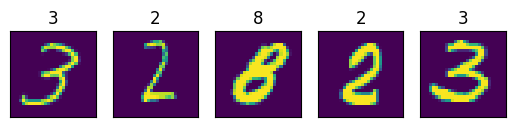

In [13]:
plot_example(X_train, y_train)

## Build Neural Network with PyTorch
Simple, fully connected neural network with one hidden layer. Input layer has 784 dimensions (28x28), hidden layer has 98 (= 784 / 8) and output layer 10 neurons, representing digits 0 - 9.

In [14]:
import torch
from torch import nn
import torch.nn.functional as F

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
mnist_dim = X.shape[1]
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(mnist.target))

In [17]:
mnist_dim, hidden_dim, output_dim

(784, 98, 10)

A Neural network in PyTorch's framework.

In [18]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        return X

skorch allows to use PyTorch's networks in the SciKit-Learn setting:

In [19]:
from skorch import NeuralNetClassifier

In [20]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=20,
    lr=0.1,
    device=device,
)

In [21]:
net.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8308       0.8900        0.3968  1.3689
      2        0.4344       0.9109        0.3132  1.0245
      3        0.3645       0.9217        0.2711  1.0056
      4        0.3252       0.9312        0.2402  1.0228
      5        0.2948       0.9370        0.2130  1.0282
      6        0.2726       0.9403        0.2002  1.0361
      7        0.2601       0.9451        0.1878  1.0091
      8        0.2487       0.9473        0.1783  1.0153
      9        0.2338       0.9487        0.1720  1.0270
     10        0.2243       0.9510        0.1618  1.0166
     11        0.2199       0.9539        0.1549  1.5117
     12        0.2061       0.9541        0.1513  1.3523
     13        0.2047       0.9561        0.1448  1.0194
     14        0.2002       0.9578        0.1393  1.0265
     15        0.1921       0.9591        0.1364  1.0565
     16        0.1886       0.9

## Prediction

In [22]:
from sklearn.metrics import accuracy_score

In [23]:
y_pred = net.predict(X_test)

In [24]:
accuracy_score(y_test, y_pred)

0.9628

An accuracy of about 96% for a network with only one hidden layer is not too bad.

Let's take a look at some predictions that went wrong:

In [25]:
error_mask = y_pred != y_test

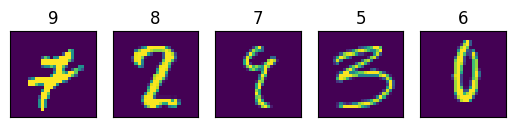

In [26]:
plot_example(X_test[error_mask], y_pred[error_mask])

# Convolutional Network
PyTorch expects a 4 dimensional tensor as input for its 2D convolution layer. The dimensions represent:
* Batch size
* Number of channel
* Height
* Width

As initial batch size the number of examples needs to be provided. MNIST data has only one channel. As stated above, each MNIST vector represents a 28x28 pixel image. Hence, the resulting shape for PyTorch tensor needs to be (x, 1, 28, 28).

In [27]:
XCnn = X.reshape(-1, 1, 28, 28)

In [28]:
XCnn.shape

(70000, 1, 28, 28)

In [29]:
XCnn_train, XCnn_test, y_train, y_test = train_test_split(XCnn, y, test_size=0.25, random_state=42)

In [30]:
XCnn_train.shape, y_train.shape

((52500, 1, 28, 28), (52500,))

In [31]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):
        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))

        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [32]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn,
    max_epochs=10,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

In [33]:
cnn.fit(XCnn_train, y_train);

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.4433       0.9703        0.0932  32.0566
      2        0.1657       0.9800        0.0652  32.6773
      3        0.1359       0.9807        0.0601  31.6219
      4        0.1129       0.9829        0.0526  32.3859
      5        0.1072       0.9843        0.0498  32.4283
      6        0.0950       0.9860        0.0459  32.5967
      7        0.0928       0.9862        0.0442  32.8216
      8        0.0848       0.9862        0.0438  32.0114
      9        0.0815       0.9884        0.0389  32.5240
     10        0.0790       0.9879        0.0380  32.0002


In [34]:
y_pred_cnn = cnn.predict(XCnn_test)

In [35]:
accuracy_score(y_test, y_pred_cnn)

0.9874857142857143

An accuracy of >98% should suffice for this example!

Let's see how we fare on the examples that went wrong before:

In [36]:
accuracy_score(y_test[error_mask], y_pred_cnn[error_mask])

0.7434715821812596

Over 70% of the previously misclassified images are now correctly identified.

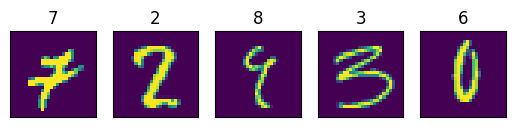

In [37]:
plot_example(X_test[error_mask], y_pred_cnn[error_mask])